## Entropy Estimation

### Plug in Entropy

위치 1에서 시작해 n에서 끝나는 문자열로 이뤄진 데이터의 시퀀스 $x_1^n$이 주어질 때 이 문자열에서 길이가 $w<n$인 모든 단어의 사전 $A^w$를 구성할 수 있다. 길이가 $w$인 임의의 단어 $y_1^w \in A^w$를 고려해 보자. $\hat{y}_w[y_1^w]$을 $x_1^n$에서 단어 $y_1^w$의 경험적 확률이라 표기하자. 즉 $\hat{y}_w[y_1^w]$는 $x_1^n$에서 $y_1^w$가 등장하는 빈도를 의미한다. 데이터가 정상성이고 ergodic process에서 생성되었다고 가정하면 대수의 법칙에 의해 고정된 $w$와 큰 수 $n$에 대해 경험적 분포 $\hat{y}_w$는 참 분포 $p_w$에 근접한다. 이런 환경에서 Entropy 비율에 대한 자연스러운 추정량은 다음과 같다.

$$\hat{H}_{n,w} = -\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$$

경험적 분포도 참 분포의 최대 우도 추정이므로 종종 최대 우도 엔트로피 추정량(Maximum Likelihood Entropy Estimator)이라 불리기도 한다. $\hat{H}_{n,w}$가 참 $H$에 만족할 만큼 근접하도록 값 $w$는 충분히 커야 한다. $w$차원의 경험적 분포가 참 분포에 근접하도록 $n$값은 $w$보다 훨씬 더 커야 한다. 아래의 과정은 Plug in Entropy 추정량을 구현하는 과정이다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from FinancialMachineLearning.features.entropy import *

data = yf.download('SPY', start = '2000-01-01', end = pd.to_datetime('today'))
data.index = pd.to_datetime(data.index)

[*********************100%%**********************]  1 of 1 completed


In [2]:
data['return'] = data['Adj Close'].pct_change()

In [3]:
data.loc[data['return'] > 0, 'bin'] = 1
data.loc[data['return'] <= 0, 'bin'] = 0

In [4]:
data['plug in entropy'] = data['bin'].rolling(window = 252).apply(
    lambda x : plug_in_entropy(x)
)

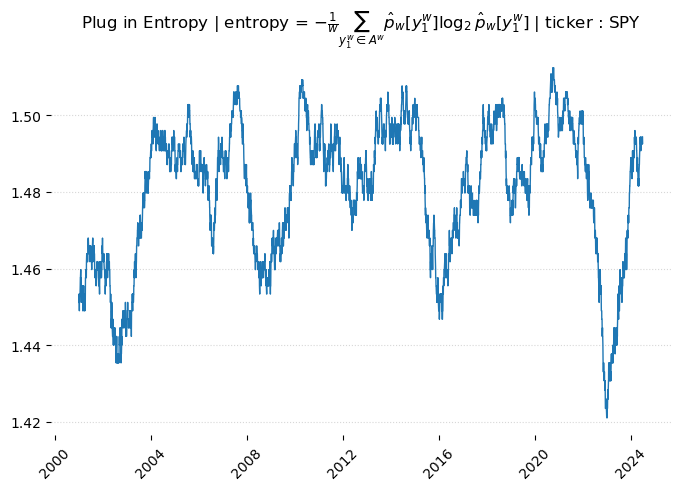

In [5]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data['plug in entropy'].index,
    data['plug in entropy'],
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title(r'Plug in Entropy | entropy = $-\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$ | ticker : SPY')
plt.show()

### Lempel-Ziv Estimator

엔트로피는 복잡도의 척도로 해석할 수 있다. 복잡한 시퀀스는 규칙적인 시퀀스에 비해 훨씬 더 많은 정보를 담고 있다. 

In [16]:
data['lempel-ziv entropy'] = data['bin'].rolling(window = 252).apply(
    lambda x : lempel_ziv_entropy(''.join(x.dropna().astype(int).astype(str).tolist()))
)

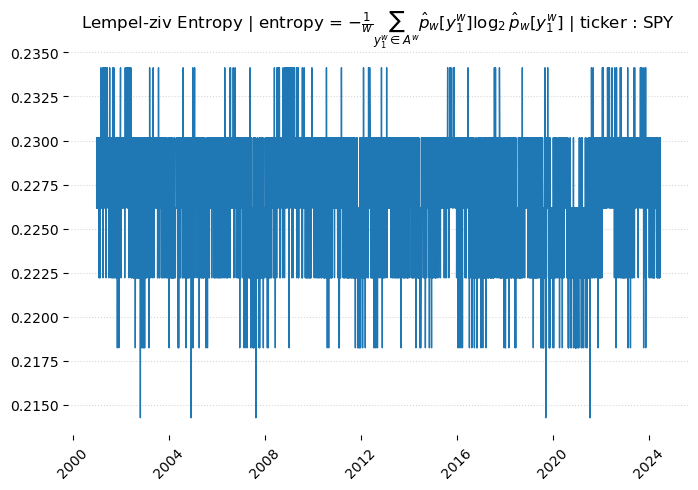

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data['lempel-ziv entropy'].index,
    data['lempel-ziv entropy'],
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title(r'Lempel-ziv Entropy | entropy = $-\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$ | ticker : SPY')
plt.show()

Kontoyiannis(1998)는 메세지에 담긴 정보를 보다 효율적으로 이용하려고 시도했다. $L_i^n$을 $i$ 앞 $n$비트에서 찾아낸 가장 긴 매치의 길이에 1을 더할 것으로 정의하자.

$$L_i^n = 1 + \max \{l \vert x_i^{i + l} = x_j^{j+l} \text{for some } i - n \leq j \leq i - 1, l \in [0,n]\}$$

아래의 코드는 가장 긴 매치의 길이를 결정하는 알고리즘을 구현한다. 몇 가지 알아둘 점은 다음과 같다.

- 값 n은 같은 너비로 이동하는 window에 대해서는 상수이며, 확장하는 window에 대해서는 $n = i$다.
- $L_i^n$을 계산하려면 데이터 $x_{i-n}^{i+n-1}$이 필요하다. 다시 말해 index $i$는 윈도우의 중앙에 있어야 한다. 이는 매치되는 양쪽 문자열의 길이가 같다는 것을 보장하는데 매우 중요하다. 이 둘의 길이가 다르면 $l$은 범위가 제한되고, 최대값은 과소 측정될 것이다
- 비록 명백히 둘 다 $i$에서 시작할 수는 없지만, 두 서브 문자열의 중복은 허용된다.

In [18]:
text = ''.join(data['bin'].dropna().astype(int).astype(str).tolist()[:20])
match_length(
    text,
    5, 
    10
) # matched length + 1, sub strings

(4, '001')

Ornstein, Weiss(1933)은 다음과 같이 공식화했다.

$$\lim_{n \rightarrow \infty} \frac{L_i^n}{\log_2(n)} = \frac{1}{H}$$

Kontoyiannis는 이 결과를 Shannon's entropy 비율을 추정하는데 이용했다. 평균 $\frac{L_i^n}{\log_2(n)}$을 계산했고, $H$를 추정하고자 역을 사용했다. 일반적인 직관에 따르면 가용한 과거를 증가시킬수록 높은 엔트로피를 가진 메세지는 상대적으로 더 짧은, 중복되지 않는 서브-문자열을 생성할 것으로 기대된다. 이와 반대로 낮은 entropy를 가진 메세지는 메세지를 분석할수록 상대적으로 더 긴 중복되지 않는 서브 문자열을 생성할 것이다. 데이터 실현값 $x_{-\infty}^{\infty}$, window 길이 $n \geq 1$, 매치 개수 $k \geq 1$가 주어질 때 moving window Lempel Ziv 추정량 $\hat{H}_{n,k} = \hat{H}_{n,k}[x_{-n+1}^{n+k-1}]$은 다음과 같이 정의된다. 

$$\hat{H}_{n,k} = \left[ \frac{1}{k} \sum_{i=1}^k \frac{L_i^n}{\log_2(n)}\right]^{-1}$$

마찬가지로 expanding window LZ 추정량 $\hat{H}_{n} = \hat{H}_{n}[x_0^{2n-1}]$는 다음과 같이 정의된다.

$$\hat{H}_n = \left[ \frac{1}{n} \sum_{i = 2}^n \frac{L_i^i}{\log_2(i)}\right]$$

window 크기 $n$은 $\hat{H}_{n,k}$를 계산할 때는 일정하므로 $L_i^n$이다. 그러나 $\hat{H}_{n}$을 계산할 때는 window 크기가 $i$를 따라 증가하므로 $L_i^i$이고, $n = \frac{N}{2}$이다. 이렇게 확장 윈도우의 경우 메세지 $N$의 길이는 모든 비트가 분석되는 것을 보장하고자 짝수여야 한다. 

앞의 식은 다음 가정하에 유도됐다. 정상성, ergodic 성질, 즉 프로세스는 유한한 많은 값을 취하고, 프로세스는 Doeblin 조건을 만족한다. 이 조건은 유한한 횟수의 단계 $r$다음에, 그 이전에 어떤 일이 있었든 모든 일이 양의 확률로 발생할 수 있다. 만약 앞의 추정량의 수정된 버전을 고려하면 Doeblin조건은 관전히 없앨 수 있다. 

$$\tilde{H}_{n,k} = \frac{1}{k} \sum_{i=1}^k \frac{\log_2(n)}{L_i^n}$$
$$\tilde{H}_{n} = \frac{1}{n} \sum_{i=2}^k \frac{\log_2(i)}{L_i^i}$$  

$\tilde{H}_{n,k}$를 계산할 때 실질적인 의문 중 하나는 윈도우 $n$의 크기를 어떻게 결정할 것 인가다. Gao(2008)의 논문에서는 $k + n = N$의 메세지 길이와 근사적으로 일치해야 한다고 주장한다. $L_i^n$의 편향이 $\mathcal{O}\left[ \frac{1}{\log_2(n)}\right]$, 분산이 $\mathcal{O}\left[\frac{1}{k}\right]$의 차수를 갖는 것을 고려하면 편향분산의 trade off는 $k \approx \mathcal{O}\left[ (\log_2(n))^2\right]$ 근처에서 균형이 된다. 즉 $n$은 $N \approx n + (\log_2(n))^2$이 되게 하는 값으로 찾을 수 있다. 예를 들어, $N = 2^8$이면 균형 편향/분산 윈도우 크기는 $n \approx 198$, 이 경우 $k \approx 58$이다.

Kontoyiannis는 $n$이 무한대로 갈 때 $\hat{H}(X)$가 Shannon's Entropy 비율에 확률 1로 수렴한다는 것을 증명했다. 아래의 코드는 Gao(2008)가 논의했던 아이디어를 구현하고 있는데, 동일한 크기의 두 서브 문자열 사이의 최대 중복성을 찾음으로써 Kontoyiannis의 추정량을 개선했다.

In [25]:
data['kontoyiannis entropy'] = data['bin'].rolling(window = 60).apply(
    lambda x : konto_entropy(x.dropna().astype(int).astype(str).tolist(), window = 252)
)

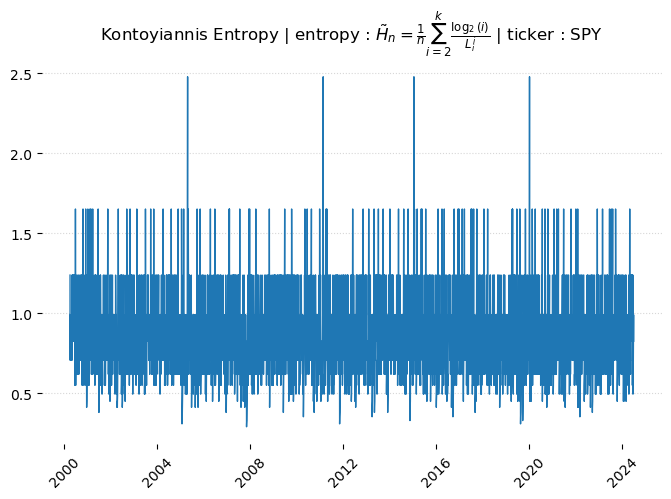

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data['kontoyiannis entropy'].index,
    data['kontoyiannis entropy'],
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title(r'Kontoyiannis Entropy | entropy : $\tilde{H}_{n} = \frac{1}{n} \sum_{i=2}^k \frac{\log_2(i)}{L_i^i}$ | ticker : SPY')
plt.show()